# Preparings

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import graphical_sampling as gs
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
import math

## Population

In [83]:
rng = gs.random.rng(seed=56)
grid_size = 30
N = 200 #grid_size**2
n = 2
# coords = rng.grid_coordinates((grid_size, 2))
# coords = np.column_stack([coords, np.zeros((10,))])
# coords = rng.random_coordinates((N, 2))
coords = rng.cluster_coordinates(2, 0.25, size=(N, 2))
probs = rng.equal_probabilities(n, N)
num_samples = 20

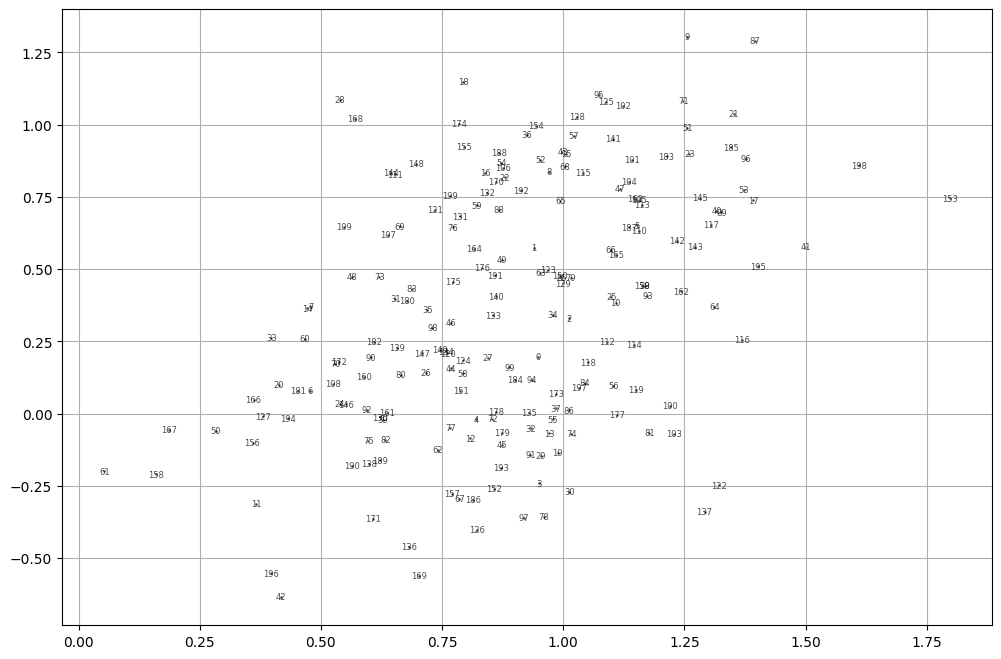

In [99]:
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], s=1, c='k', alpha=0.5)

# add an index label to each point
for i, (x, y) in enumerate(coords):
    plt.text(x, y, str(i),
             fontsize=6,      # adjust size so it’s legible but not overwhelming
             alpha=0.7,       # match somewhat with points
             ha='center',     # horizontal alignment
             va='center')     # vertical alignment

plt.grid()
plt.show()

## Samples

### Random and Method

In [101]:
kss = gs.sampling.KMeansSampling(coords, probs, n=n, n_zones=(2, 2), tolerance=5, split_size=.001)
method_samples = kss.sample(num_samples)

In [102]:
ran = gs.sampling.RandomSampling(coords, probs, n=n)
random_samples = ran.sample(num_samples)

### Hand-pick

In [103]:
def two_d_index_to_flat_index(index):
    return (index[0]-1) + (index[1]-1) * grid_size

def generate_initial_points(mode):
    if mode == 'center':
        first_point = np.array([grid_size//2, grid_size//2])
        return [
            first_point,
            first_point+np.array([0, 1]),
            first_point+np.array([1, 0]),
            first_point+np.array([1, 1])
        ]
    if mode == 'centroid':
        first_point = np.array([int(np.ceil(grid_size/4)), int(np.ceil(grid_size/4))])
        return [
            first_point,
            first_point+np.array([0, grid_size//2]),
            first_point+np.array([grid_size//2, 0]),
            first_point+np.array([grid_size//2, grid_size//2])
        ]

def generate_samples(initial, step_directions, n_samples):
    samples = [[two_d_index_to_flat_index(point) for point in initial]]
    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + np.array(step_direction) * i
            new_point_flat = two_d_index_to_flat_index(new_point)
            if (
                new_point[0] < 1 or new_point[0] > grid_size or
                new_point[1] < 1 or new_point[1] > grid_size or
                new_point_flat < 0 or new_point_flat >= N
            ):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)
    return np.array(samples)

def find_closest_index(point, grid):
    distances = np.linalg.norm(grid - point, axis=1)
    return np.argmin(distances)

def generate_closest_index_based_samples(n_samples):
    d = 0.01
    initial = [
        [0.5-d, 0.5-d],
        [0.5-d, 0.5+d],
        [0.5+d, 0.5-d],
        [0.5+d, 0.5+d]
    ]
    samples = [[find_closest_index(np.array(point), coords) for point in initial]]
    d = 0.05
    step_directions = np.array([
        [-d, -d],
        [-d, d],
        [d, -d],
        [d, d]
    ])
    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + step_direction * i
            new_point_flat = find_closest_index(new_point, coords)
            if (
                new_point[0] > 1 or new_point[0] < 0 or
                new_point[1] > 1 or new_point[1] < 0
            ):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)
    return np.array(samples)

def generate_closest_index_based_samples2(n_samples, n_clusters, angle = 0):
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False) + angle
    radius = 0.05
    step_directions = np.column_stack((np.cos(angles), np.sin(angles))) * radius

    initial = [[0.5, 0.5] + step for step in step_directions]
    samples = [[find_closest_index(np.array(point), coords) for point in initial]]

    for i in range(1, n_samples):
        sample = []
        for point, step_direction in zip(initial, step_directions):
            new_point = np.array(point) + step_direction * i
            new_point_flat = find_closest_index(new_point, coords)
            if np.any(new_point < 0) or np.any(new_point > 1):
                return np.array(samples)
            sample.append(new_point_flat)
        samples.append(sample)

    return np.array(samples)


In [104]:
initials = generate_initial_points('center')
handpick_samples = generate_samples(
    initials,
    [(-1, -1), (-1, 1), (1, -1), (1, 1)],
    num_samples
)
handpick_closest_samples = generate_closest_index_based_samples2(num_samples, n, angle=np.pi/4)

# Plots

In [9]:
def assign_samples_to_clusters(samples, centroids):
    cost_matrix = np.linalg.norm(samples[:, :, np.newaxis] - centroids, axis=3).transpose(0, 2, 1)
    return np.array([samples[i][linear_sum_assignment(cost_matrix[i])[1]] for i in range(samples.shape[0])])

def plot_samples(coords, samples, centroids, labels, measures=None, plot_centroids=True, plot_lines=True):
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()

    assigned_samples = assign_samples_to_clusters(samples, centroids)

    for i, sample in enumerate(assigned_samples):
        ax = axes[i]
        ax.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.7)
        ax.scatter(sample[:, 0], sample[:, 1], c="red", marker="*", s=200)

        if plot_centroids:
            ax.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="X", s=100)

        if plot_lines:
            for j in range(assigned_samples.shape[1]):
                ax.plot([sample[j, 0], centroids[j, 0]], [sample[j, 1], centroids[j, 1]], c='black', linestyle='--')

        if measures:
            ax.set_title(', '.join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    for ax in axes[assigned_samples.shape[0]:]:
        fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.3)


def plot_densities(densities, measures=None, color='red'):
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.flatten()
    for i, density in enumerate(densities):
        ax = axes[i]
        ax.scatter(density[0], density[1], c=color, alpha=0.7)
        ax.plot([0, 1], [0, 1], c='black')

        if measures:
            ax.set_title(', '.join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    for ax in axes[len(densities):]:
        fig.delaxes(ax)

    plt.subplots_adjust(hspace=0.3)


def plot_convex_hull(
        points, ax, color, alpha=0.3, edge_color="black", line_width=1.0
    ):
        if len(points) < 3:
            return ax, None
        hull = ConvexHull(points)
        polygon = Polygon(
            points[hull.vertices],
            closed=True,
            facecolor=color,
            alpha=alpha,
            edgecolor=edge_color,
            lw=line_width,
        )
        ax.add_patch(polygon)
        return ax, hull


def grand_plot(clusters, centroids, samples, densities, measures=None):
    num_rows = samples.shape[0]
    fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3.5*num_rows))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    for i in range(num_rows):
        ax = axes[i, 0]

        for cluster_idx, cluster in enumerate(clusters):
            cluster_points = cluster[:, 1:3]
            cluster_color = plt.cm.tab10(cluster_idx % 10)
            ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
            ax.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=cluster_color,
                s=cluster[:, 3]*1000,
                alpha=0.8,
            )


        ax.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="X", s=100, alpha=0.5)
        ax.scatter(assigned_samples[i, :, 0], assigned_samples[i, :, 1], c="black", marker="*", s=200)

        for j in range(samples.shape[1]):
            ax.plot([assigned_samples[i, j, 0], centroids[j, 0]], [assigned_samples[i, j, 1], centroids[j, 1]], c='black', linestyle='--')

        if measures:
            ax.set_title(', '.join(str(round(measure[i], 2)) for measure in measures))

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


        ax = axes[i, 1]
        ax.scatter(densities[i][0], densities[i][1], c='red', alpha=0.6)
        maximum = max(np.max(densities[i][0]), np.max(densities[i][1]), 0.9)
        ax.plot([0, maximum+0.1], [0, maximum+0.1], c='black')

        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


        ax = axes[i, 2]
        data = densities[i][1] - densities[i][0]
        bin_width = 0.1
        bins = np.arange(min(data), max(data) + bin_width, bin_width)

        ax.hist(data, bins=bins, edgecolor='black', alpha=0.6, color='blue')
        ax.grid(alpha=0.5)
        ax.set_xticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])


    plt.subplots_adjust(hspace=0.3)


def grand_plot2(clusters, centroids, samples, densities, measures=None):
    num_samples = samples.shape[0]
    num_rows = num_samples // 2  # Each row contains two samples (4 plots total)
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3.5 * num_rows))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    for i in range(num_rows):
        for j in range(2):  # Two samples per row
            sample_idx = 2 * i + j  # Compute the sample index
            if sample_idx >= num_samples:
                break

            ax = axes[i, 2 * j]  # First plot (Convex Hull)
            for cluster_idx, cluster in enumerate(clusters):
                cluster_points = cluster[:, 1:3]
                cluster_color = plt.cm.tab10(cluster_idx % 10)
                ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.2)
                ax.scatter(
                    cluster_points[:, 0],
                    cluster_points[:, 1],
                    color=cluster_color,
                    s=cluster[:, 3] * 1000,
                    alpha=0.8,
                )

            ax.scatter(centroids[:, 0], centroids[:, 1], c="black", marker="X", s=100, alpha=0.5)
            ax.scatter(assigned_samples[sample_idx, :, 0], assigned_samples[sample_idx, :, 1], c="black", marker="*", s=200)

            for k in range(samples.shape[1]):
                ax.plot([assigned_samples[sample_idx, k, 0], centroids[k, 0]], [assigned_samples[sample_idx, k, 1], centroids[k, 1]], c='black', linestyle='--')

            if measures:
                ax.set_title(', '.join(str(round(measure[sample_idx], 2)) for measure in measures))

            ax.grid(alpha=0.5)
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            ax = axes[i, 2 * j + 1]  # Second plot (Density Scatter)
            ax.scatter(densities[sample_idx][0], densities[sample_idx][1], c='red', alpha=0.6)
            maximum = max(np.max(densities[sample_idx][0]), np.max(densities[sample_idx][1]), 0.9)
            ax.plot([0, maximum + 0.1], [0, maximum + 0.1], c='black')

            ax.grid(alpha=0.5)
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.subplots_adjust(hspace=0.3)


# Main

In [100]:
density_measure = gs.measure.Density(coords, probs, n, 0.001)
clusters, centroids, labels = density_measure.clusters, density_measure.centroids, density_measure.labels

In [108]:
chosen_samples = np.array([
    [27, 133],
    [76, 74],
    [11, 87]
])

In [109]:
method_scores, method_densities = density_measure.score(method_samples)

random_scores, random_densities = density_measure.score(random_samples)

handpick_scores, handpick_densities = density_measure.score(handpick_closest_samples)

chosen_scores, chosen_densities = density_measure.score(chosen_samples)

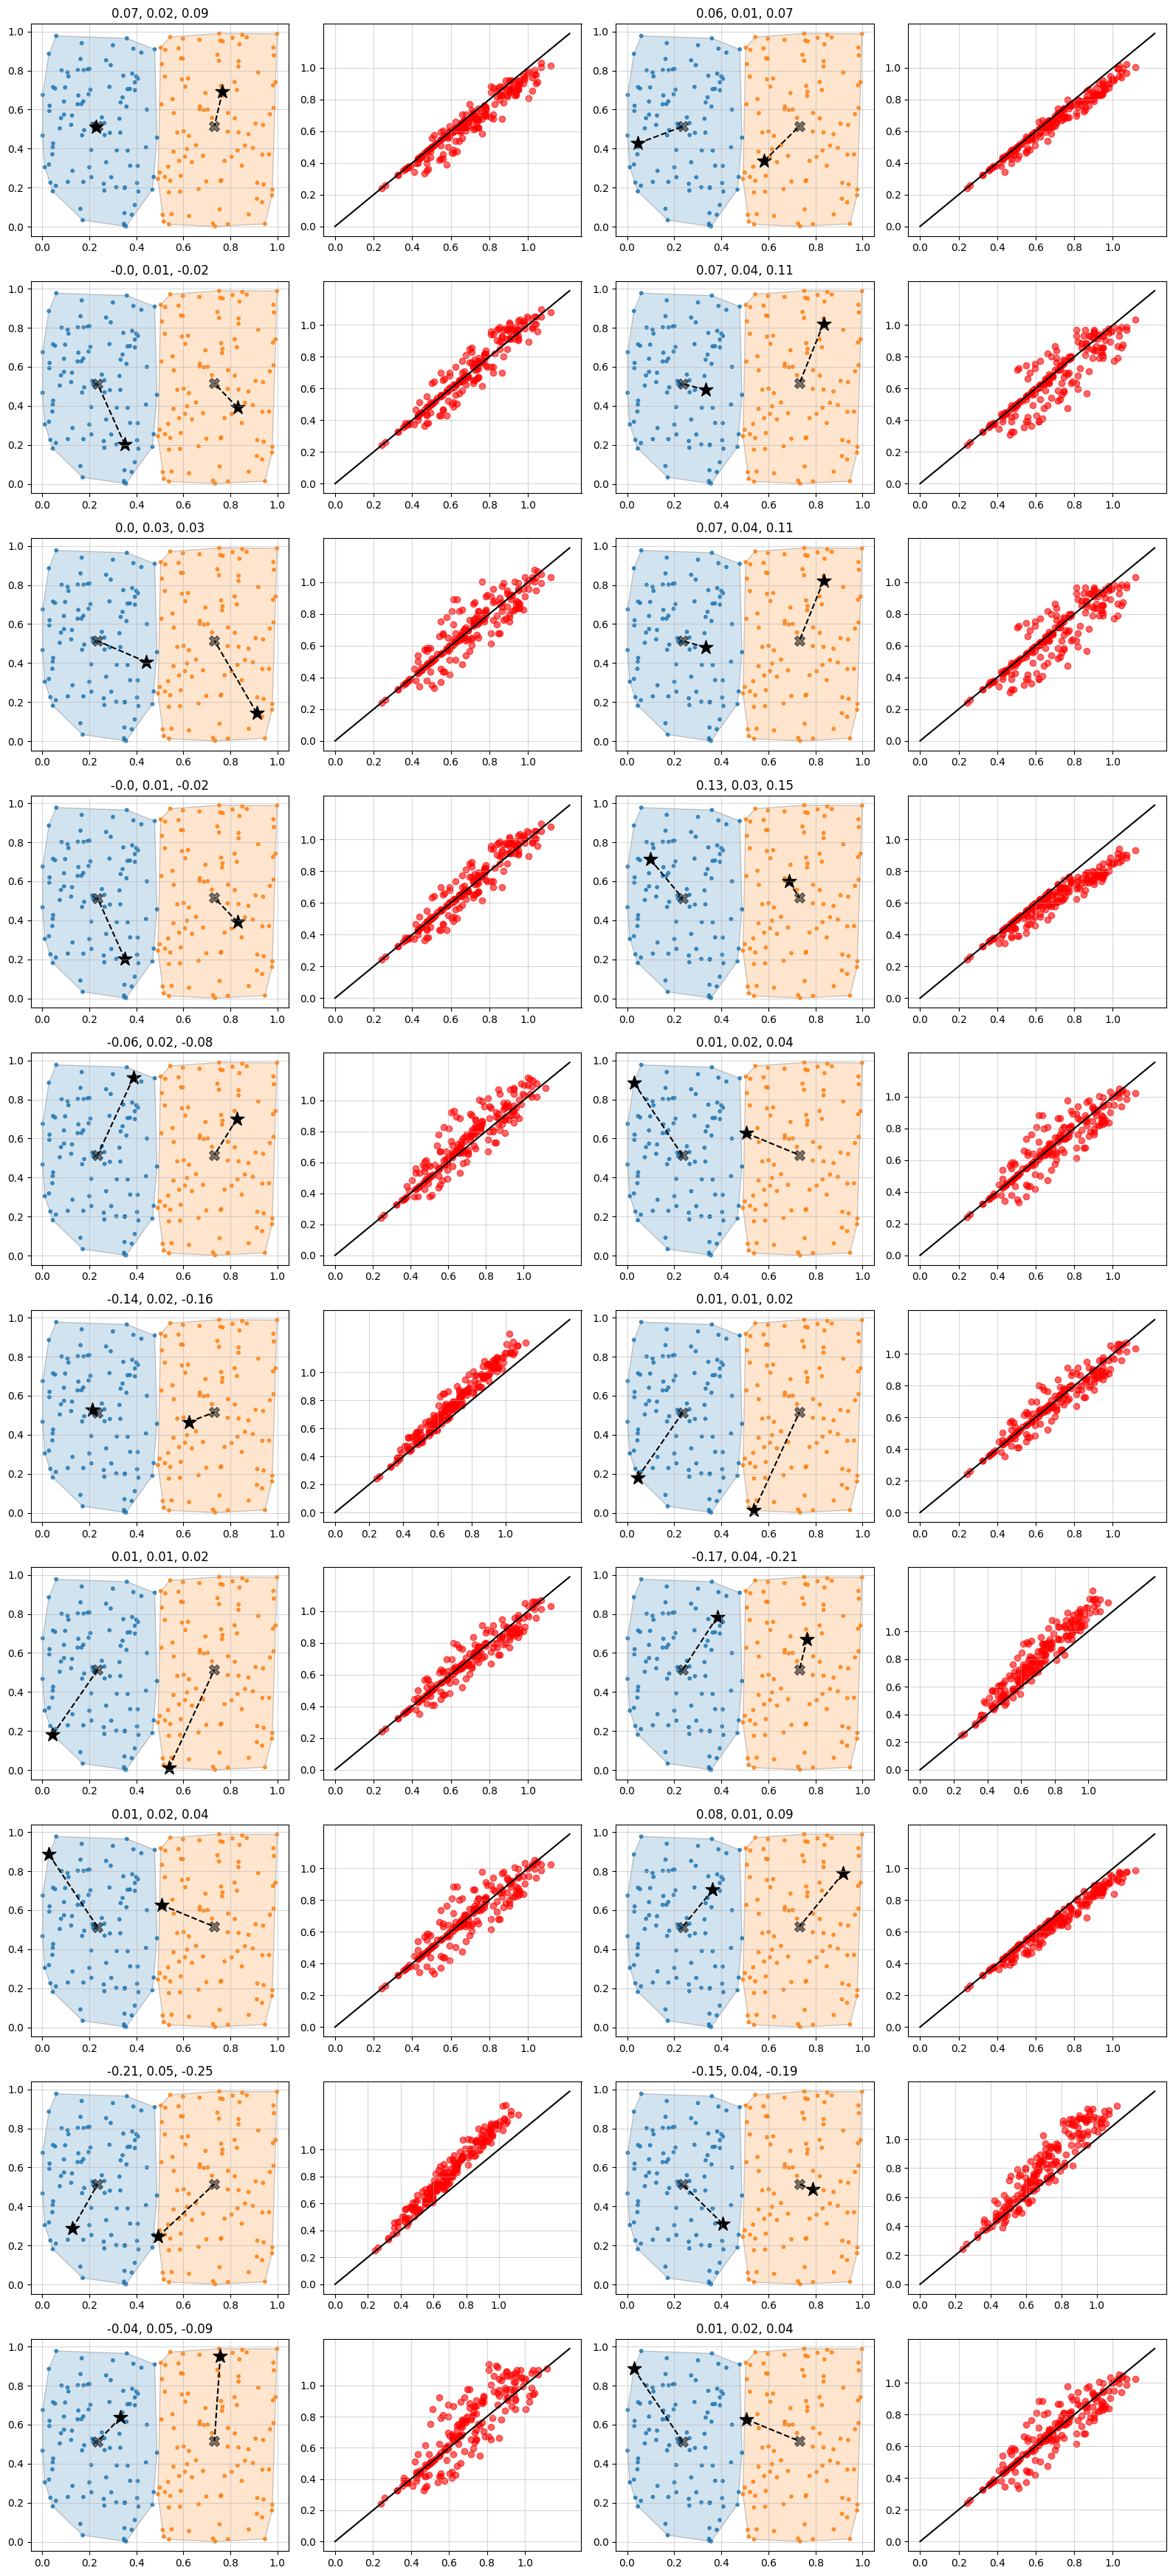

In [33]:
grand_plot2(clusters, centroids, method_samples, method_densities, method_scores)
plt.tight_layout()
plt.savefig('method.png', dpi=150)

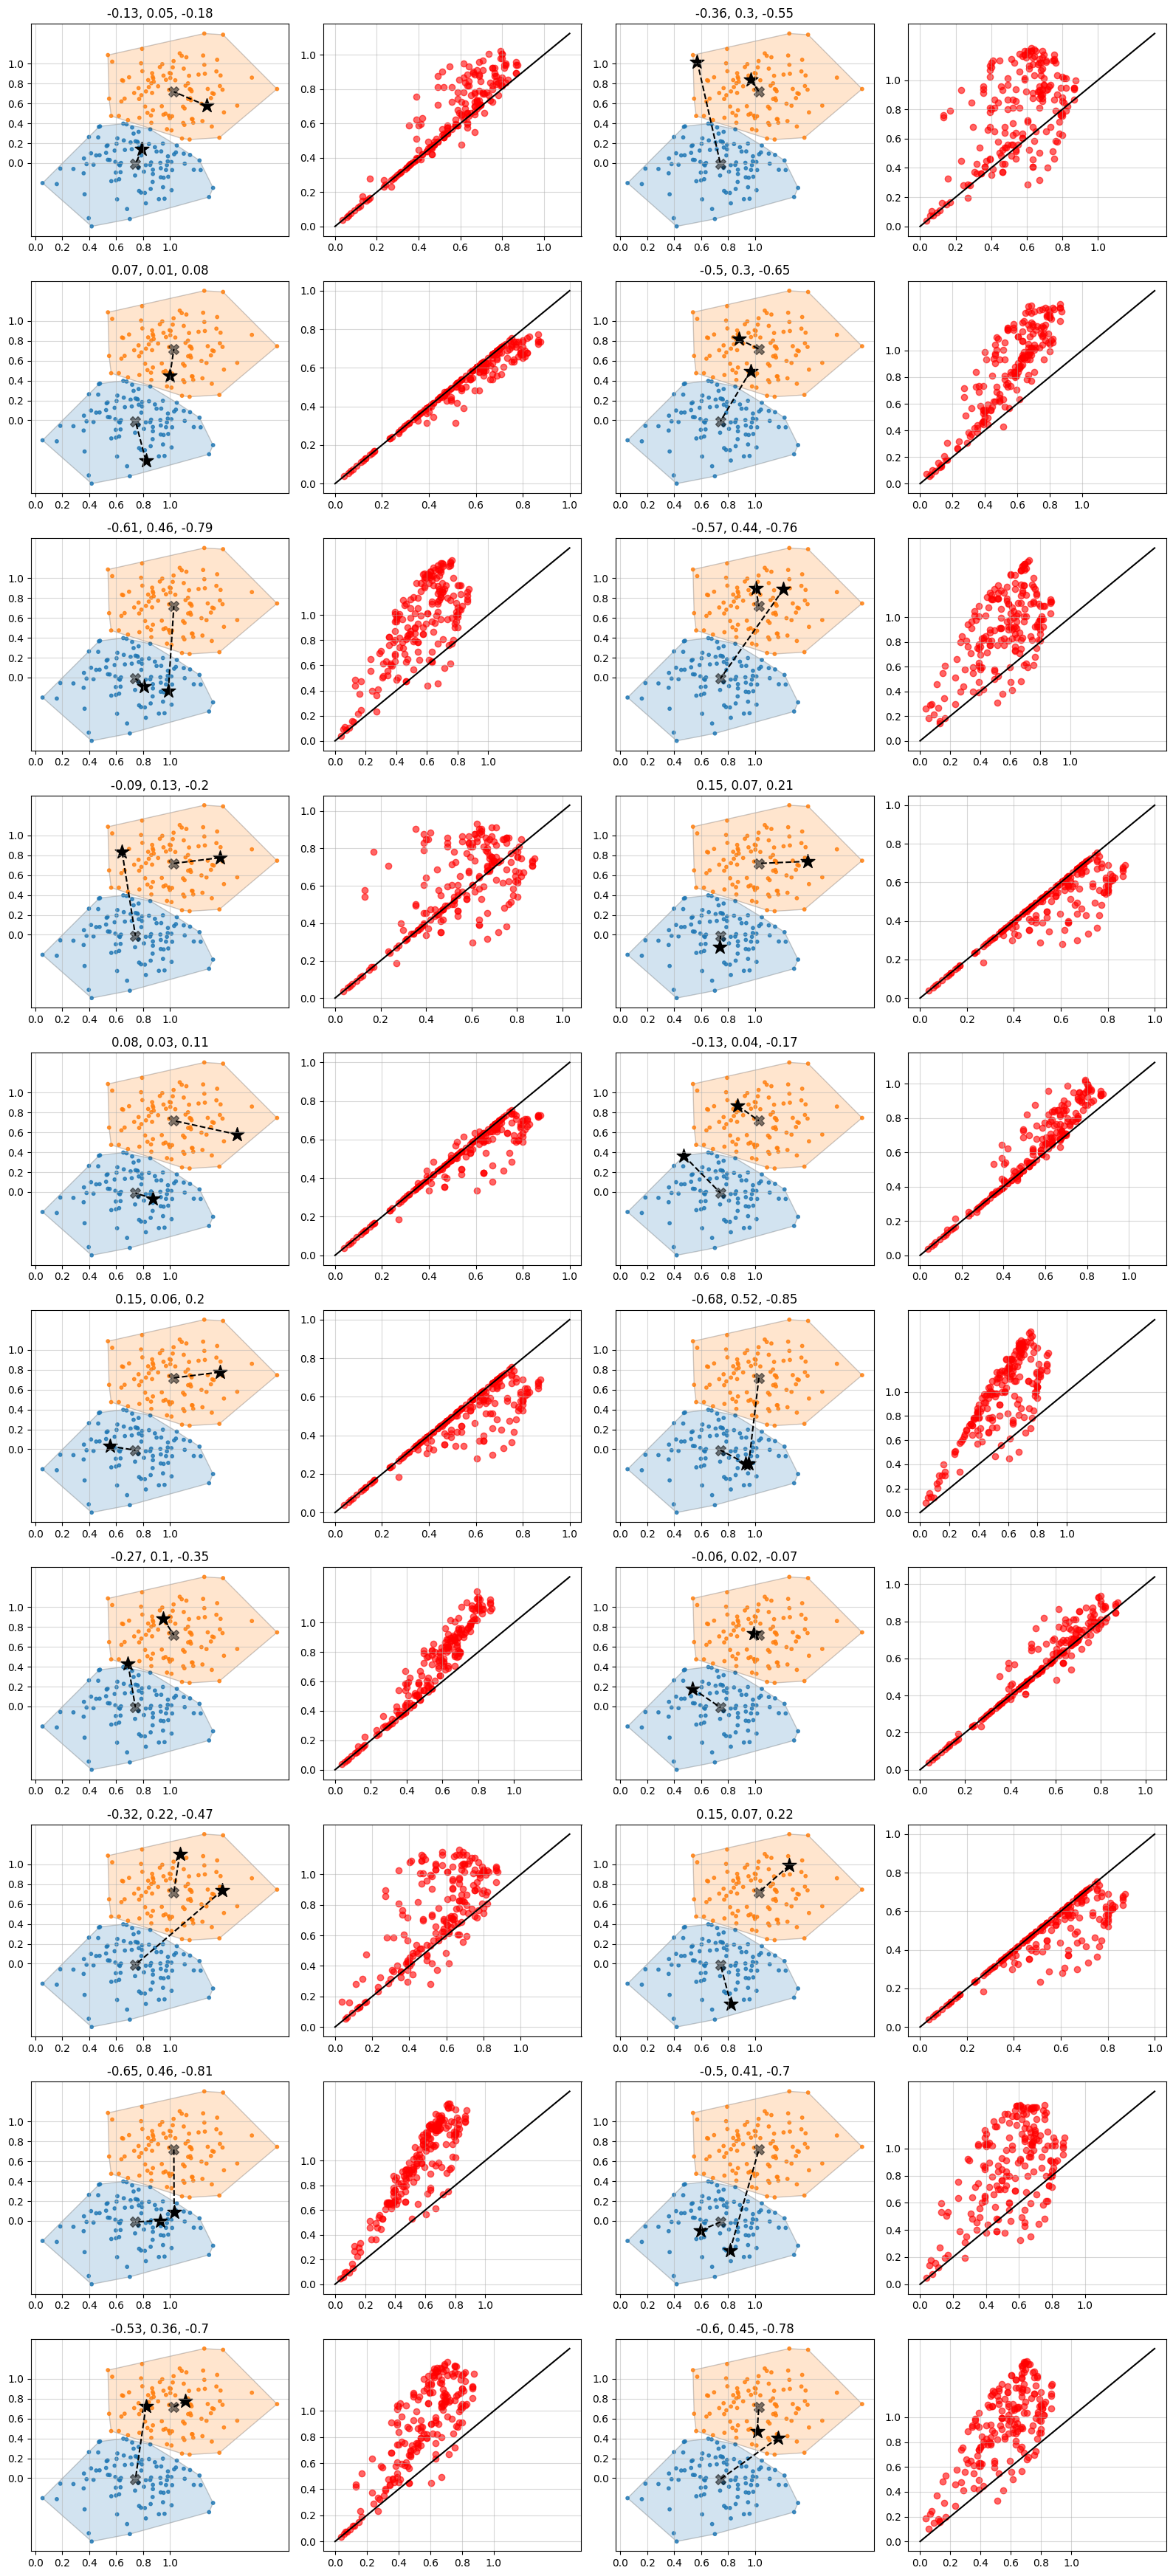

In [92]:
grand_plot2(clusters, centroids, random_samples, random_densities, random_scores)
plt.tight_layout()
plt.savefig('random.png', dpi=150)

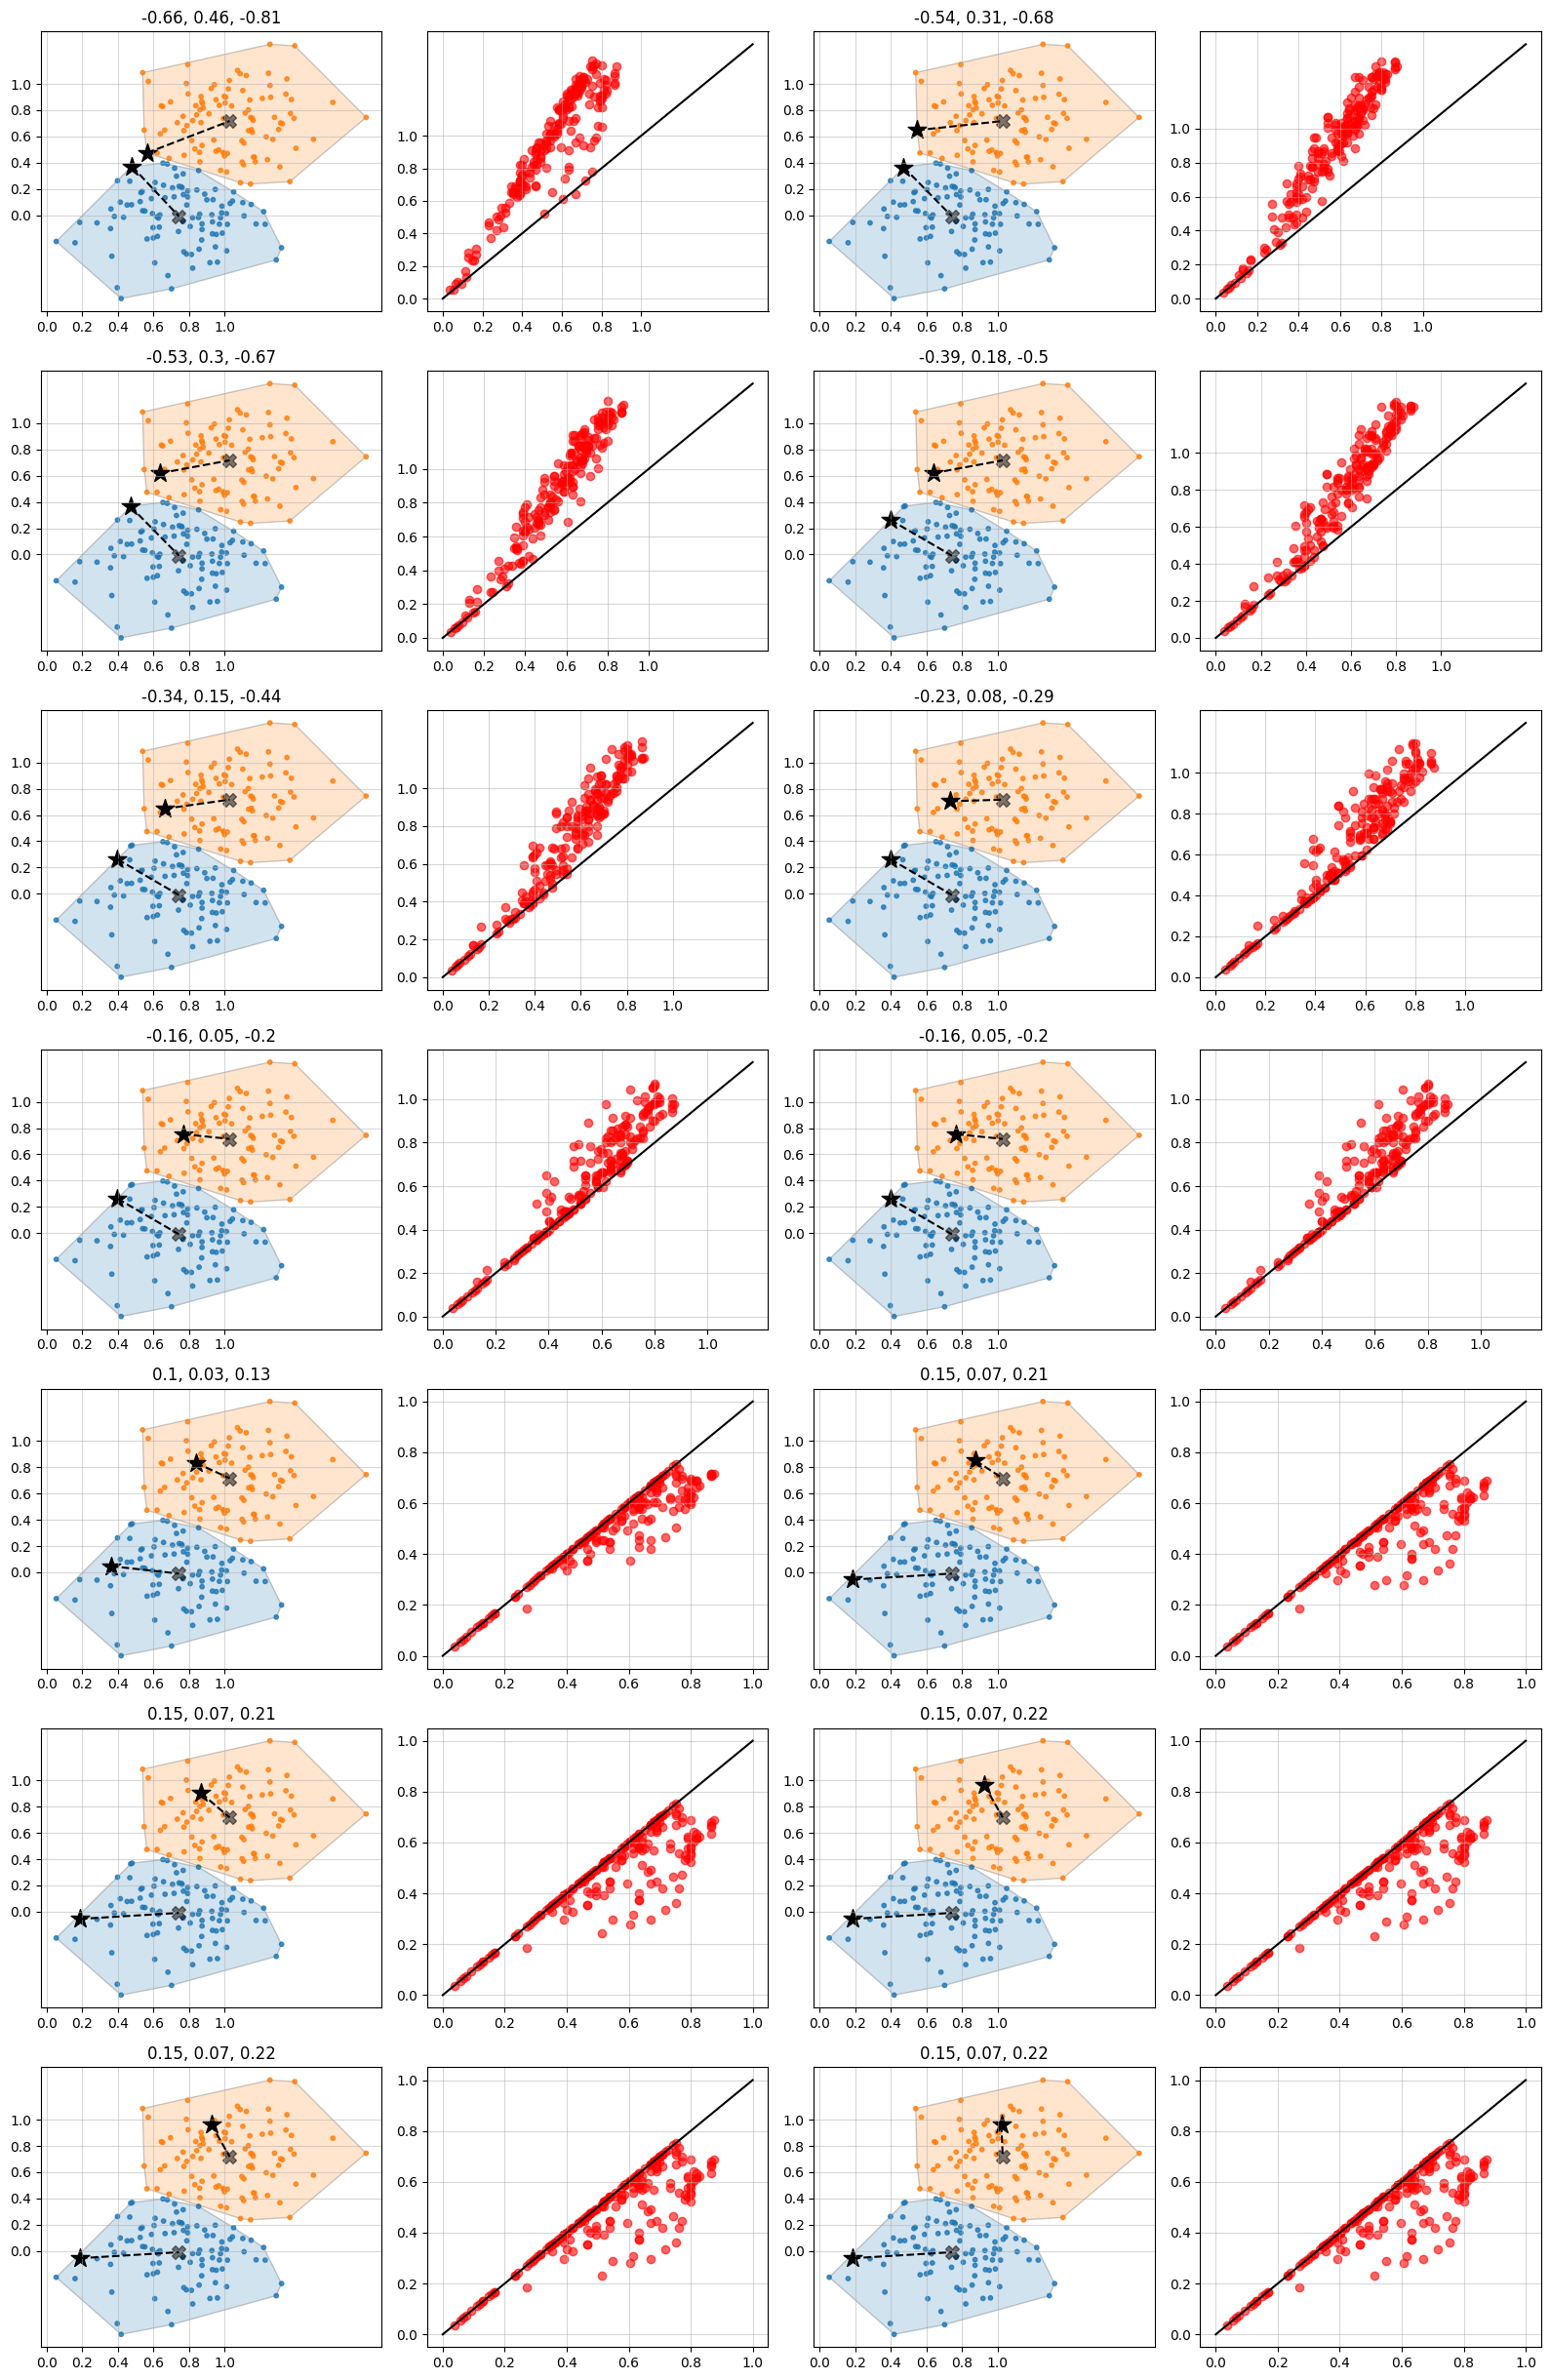

In [91]:
grand_plot2(clusters, centroids, handpick_closest_samples, handpick_densities, handpick_scores)
plt.tight_layout()
plt.savefig('handpick.png', dpi=150)

In [129]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from matplotlib.patches import FancyArrowPatch

def grand_plot_all(clusters, centroids, labels, samples, densities, coords, measures=None, index=None, cdens=None):
    """
    clusters:   list of arrays, each array is of shape (n_points_in_cluster, ≥4),
                where columns [1:3] are the x,y of each point and column 3 is used for sizing the scatter.
    centroids:  (n_clusters, 2) array of cluster centers in the same coordinate space as `coords`.
    samples:    some integer‐index array used to pick which coords get “assigned” to which centroids.
                In particular, `coords[samples]` is fed into assign_samples_to_clusters.
    densities:  list or array of length = n_samples; for the final subplot (unchanged here).
    coords:     (N, 2) array of all data‐point coordinates.  **We now use this to build the KDE.**
    measures:   optional list of measure‐arrays, only used to title the first subplot if provided.
    index:      integer index into both `samples` and `densities` for highlighting one sample.

    Produces three side‐by‐side panels:
      [0] Clusters (with convex hulls, centroids, one sample’s assigned points + lines)
      [1] 2D‐KDE over “coords” (uniform kernel), with raw coords overlaid
      [2] Scatter of (original_density vs. translated_density) for the selected sample
    """
    # ——————————————————————————————————————————————————————————————————————————————
    # Create a 1×3 figure, side by side:
    fig, axes = plt.subplots(3, 4, figsize=(16, 11))

    for i in range(3):

        sample_idx = index[i]

        # ——————————————————————————————————————————————————————————————————————————————
        # SECOND SUBPLOT: 2D KDE over “coords” using a uniform (“tophat”) kernel
        ax = axes[i, 0]
        # We take all of coords → shape (N, 2)
        data = coords.copy()

        # Fit KernelDensity with uniform (“tophat”) kernel
        kde = KernelDensity(kernel='tophat', bandwidth='scott')
        kde.fit(data)

        bandwidth = kde.bandwidth_  # Get the bandwidth used by the KDE

        # Determine grid‐bounds based on coords’ ranges (with a small margin)
        x_min, x_max = data[:, 0].min(), data[:, 0].max()
        y_min, y_max = data[:, 1].min(), data[:, 1].max()
        # Add a small margin equal to 1×bandwidth so contours don’t clip
        x_margin = bandwidth
        y_margin = bandwidth
        x_lin = np.linspace(x_min - x_margin, x_max + x_margin, 100)
        y_lin = np.linspace(y_min - y_margin, y_max + y_margin, 100)
        xx, yy = np.meshgrid(x_lin, y_lin)
        grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

        # Evaluate log‐density on each grid point and exponentiate to get density
        log_dens = kde.score_samples(grid_points)
        zz = np.exp(log_dens).reshape(xx.shape)

        # Draw a filled contour
        cf = ax.contourf(
            xx,
            yy,
            zz,
            levels=20,
            cmap=cdens,
            alpha=0.6
        )
        # Overlay the raw coords as tiny gray dots
        ax.scatter(data[:, 0], data[:, 1], c='black', s=10, alpha=0.35, label='raw coords')

        # ax.set_title('2D KDE of all coords (Uniform Kernel)')
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # ax.set_xlim(x_min - x_margin, x_max + x_margin)
        # ax.set_ylim(y_min - y_margin, y_max + y_margin)
        ax.grid(alpha=0.3)
        # ax.legend(loc='upper right', fontsize='small')

        if i == 0:
            ax.set_title('Original KDE', fontsize=16)



        # ——————————————————————————————————————————————————————————————————————————————
        # FIRST SUBPLOT: clusters + convex hulls + centroids + one sample’s assignments
        ax = axes[i, 1]
        assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

        interval = 0.2

        colors = [plt.cm.tab10(0), plt.cm.tab10(3)]

        # Plot each cluster’s convex hull and scatter
        for cluster_idx, cluster in enumerate(clusters):
            cluster_points = cluster[:, 1:3]  # columns 1 and 2 are x,y
            # cluster_color = plt.cm.tab10(cluster_idx % 10)
            cluster_color = colors[cluster_idx]
            ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.1)
            ax.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=cluster_color,
                s=cluster[:, 3] * 800,
                alpha=0.4,
            )
        # Centroids
        ax.scatter(centroids[:, 0], centroids[:, 1], c="black", s=50, alpha=0.6)
        # Highlight the “assigned” points for the chosen sample:
        ax.scatter(
            assigned_samples[sample_idx, :, 0],
            assigned_samples[sample_idx, :, 1],
            c="black",
            # marker="^",
            s=50
        )
        # Draw dashed lines from each assigned point to its centroid
        for k in range(assigned_samples.shape[1]):
            # ax.plot(
            #     [assigned_samples[sample_idx, k, 0], centroids[k, 0]],
            #     [assigned_samples[sample_idx, k, 1], centroids[k, 1]],
            #     c='black',
            #     linestyle='--'
            # )
            end = assigned_samples[sample_idx, k]
            start   = centroids[k]

            # ax.annotate(
            #     "",               # no text
            #     xy=start,           # arrow tip
            #     xytext=end,     # arrow tail
            #     arrowprops=dict(
            #         arrowstyle="->",
            #         color="black",
            #         linestyle="--",
            #         lw=1         # line‐width of the dashes
            #     )
            # )

            arrow = FancyArrowPatch(
                posA=start, posB=end,
                arrowstyle='->',
                # linestyle='--',
                mutation_scale=20,  # size of the arrow‐head
                color='black',
                lw=1.5                # dash‐width
            )
            ax.add_patch(arrow)

        # If measures are provided, show them in the title
        if measures:
            ax.set_title(', '.join(f"{m[sample_idx]:.2f}" for m in measures))
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        ax.grid(alpha=0.5)
        # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])


        if i == 0:
            ax.set_title('Clusters & Samples', fontsize=16)


        # ——————————————————————————————————————————————————————————————————————————————
        # SECOND SUBPLOT: 2D KDE over “coords” using a uniform (“tophat”) kernel
        ax = axes[i, 2]
        # We take all of coords → shape (N, 2)
        data = coords.copy()

        shifts = assigned_samples[sample_idx] - centroids
        for j, shift in enumerate(shifts):
            data[labels == j] += shift

        # Fit KernelDensity with uniform (“tophat”) kernel
        kde = KernelDensity(kernel='tophat', bandwidth='scott')
        kde.fit(data)

        bandwidth = kde.bandwidth_  # Get the bandwidth used by the KDE

        # Determine grid‐bounds based on coords’ ranges (with a small margin)
        x_min, x_max = data[:, 0].min(), data[:, 0].max()
        y_min, y_max = data[:, 1].min(), data[:, 1].max()
        # Add a small margin equal to 1×bandwidth so contours don’t clip
        x_margin = bandwidth
        y_margin = bandwidth
        x_lin = np.linspace(x_min - x_margin, x_max + x_margin, 100)
        y_lin = np.linspace(y_min - y_margin, y_max + y_margin, 100)
        xx, yy = np.meshgrid(x_lin, y_lin)
        grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

        # Evaluate log‐density on each grid point and exponentiate to get density
        log_dens = kde.score_samples(grid_points)
        zz = np.exp(log_dens).reshape(xx.shape)

        # Draw a filled contour
        cf = ax.contourf(
            xx,
            yy,
            zz,
            levels=20,
            cmap=cdens,
            alpha=0.6
        )
        # Overlay the raw coords as tiny gray dots
        ax.scatter(data[:, 0], data[:, 1], c='black', s=10, alpha=0.35, label='raw coords')

        # ax.set_title('2D KDE of all coords (Uniform Kernel)')
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        # ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        # ax.set_xlim(x_min - x_margin, x_max + x_margin)
        # ax.set_ylim(y_min - y_margin, y_max + y_margin)
        ax.grid(alpha=0.3)
        # ax.legend(loc='upper right', fontsize='small')

        if i == 0:
            ax.set_title('Translated KDE', fontsize=16)


        # ——————————————————————————————————————————————————————————————————————————————
        # THIRD SUBPLOT: density‐vs‐density scatter (unchanged)
        ax = axes[i, 3]
        # ax.text(
        #     0.05,
        #     0.95,
        #     str(sample_idx + 1),
        #     transform=ax.transAxes,
        #     fontsize=24,
        #     color='black',
        #     alpha=0.8,
        #     weight='bold',
        #     va='top'
        # )

        x_dens = densities[sample_idx][0]  # “original” density
        y_dens = densities[sample_idx][1]  # “translated” density
        ax.scatter(x_dens, y_dens, c='red', alpha=0.5)

        # Compute the maximum for the ticks & diagonal line
        max_val = max(x_dens.max(), y_dens.max(), 0)
        tick_max = math.ceil(max_val / interval) * interval
        ticks = np.arange(0, tick_max + interval * 0.5, interval)

        # Diagonal reference line
        ax.plot([0, tick_max], [0, tick_max], c='black')

        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xlim(0, tick_max)
        ax.set_ylim(0, tick_max)
        ax.grid(alpha=0.5)
        ax.set_xlabel('Original Density')
        ax.set_ylabel('Translated Density')

        # if i == 0:
        #     ax.set_title('Density Plot', fontsize=16)

    # ——————————————————————————————————————————————————————————————————————————————
    plt.tight_layout()
    # plt.show()

In [151]:
colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r']

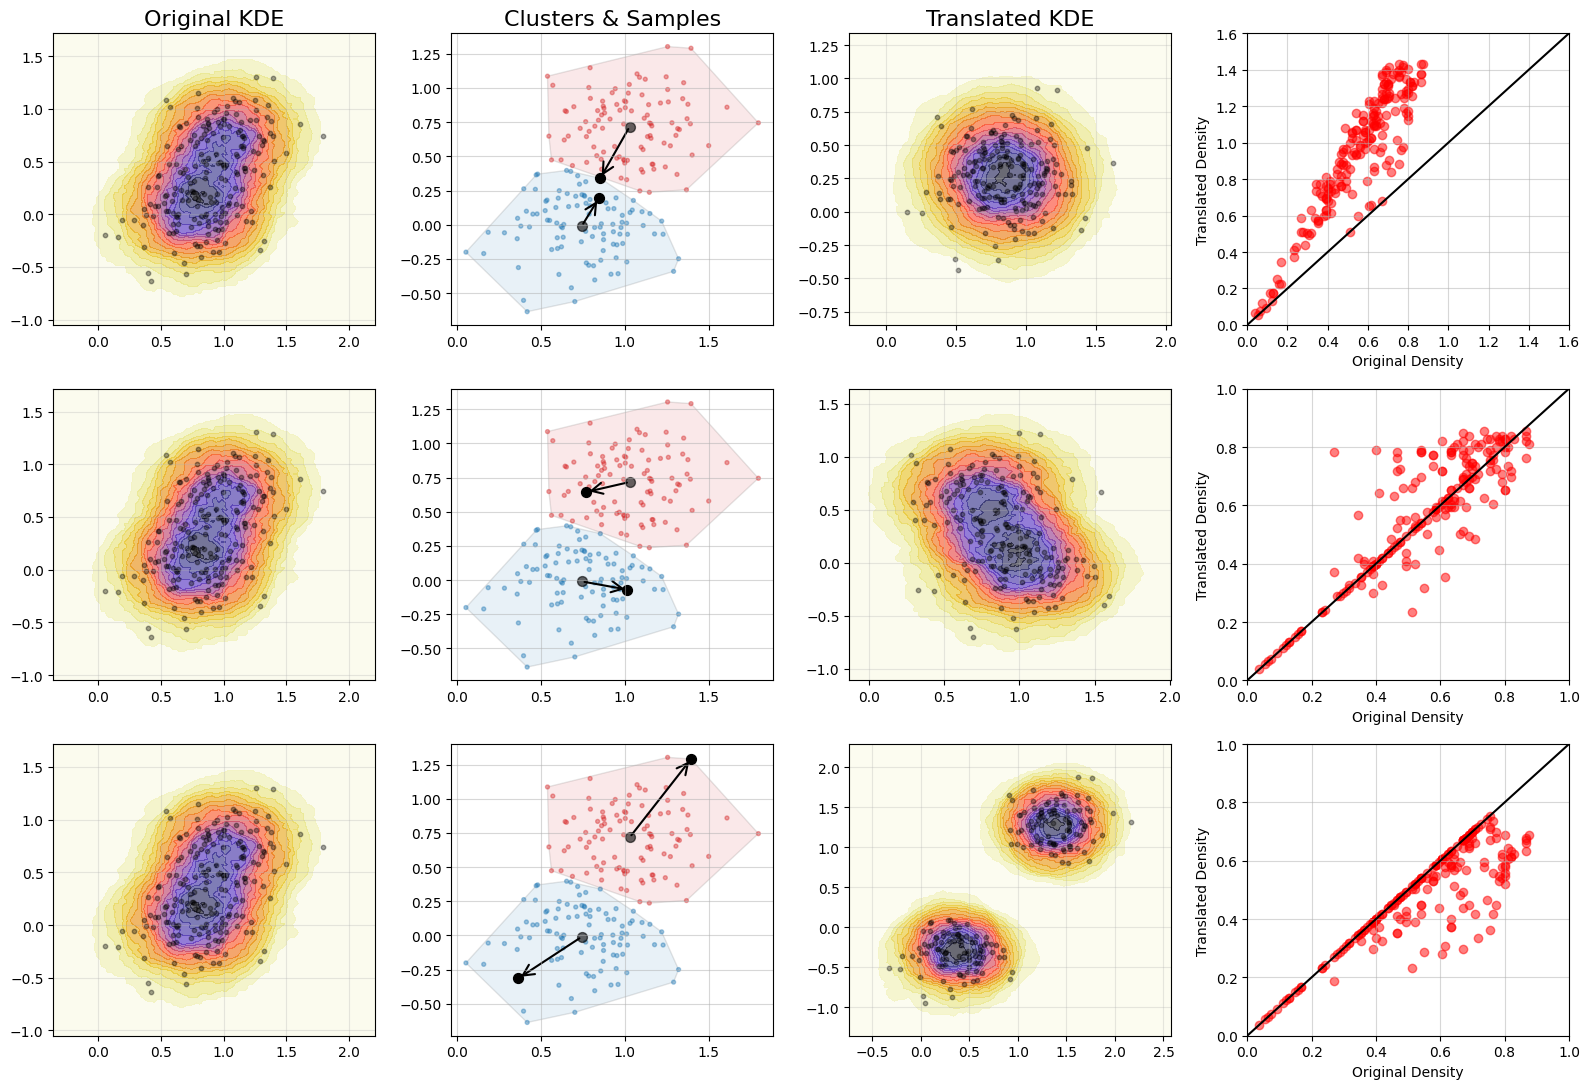

In [130]:
# for color in colors:
#     print(color)
grand_plot_all(clusters, centroids, labels, chosen_samples, chosen_densities, coords, index=[0, 1, 2], cdens='CMRmap_r')
plt.savefig('kde_all.png', dpi=300)

In [ ]:
def grand_plot25(clusters, centroids, samples, densities, measures=None, index=None):
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    interval = 0.2

    for j in range(3):
            # plot_num = 2 * i + j
        sample_idx = index[j]  # the sample index to display

        # First subplot: Convex Hull + assignments
        ax = axes[0, j]
        # draw big semi-transparent index in upper left
        # ax.text(
        #     0.05, 0.95, str(plot_num+1),
        #     transform=ax.transAxes,
        #     fontsize=24, color='black',
        #     alpha=0.8, weight='bold',
        #     va='top'
        # )

        for cluster_idx, cluster in enumerate(clusters):
            cluster_points = cluster[:, 1:3]
            cluster_color = plt.cm.tab10(cluster_idx % 10)
            ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.1)
            ax.scatter(
                cluster_points[:, 0],
                cluster_points[:, 1],
                color=cluster_color,
                s=cluster[:, 3] * 800,
                alpha=0.4,
            )

        ax.scatter(centroids[:, 0], centroids[:, 1], c="black", s=50, alpha=0.6)
        ax.scatter(
            assigned_samples[sample_idx, :, 0],
            assigned_samples[sample_idx, :, 1],
            c="black", marker="^", s=150
        )
        for k in range(samples.shape[1]):
            ax.plot(
                [assigned_samples[sample_idx, k, 0], centroids[k, 0]],
                [assigned_samples[sample_idx, k, 1], centroids[k, 1]],
                c='black', linestyle='--'
            )
        if measures:
            ax.set_title(', '.join(f"{m[sample_idx]:.2f}" for m in measures))
        ax.grid(alpha=0.5)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])



        # Second subplot: Density scatter
        ax = axes[1, j]
        ax.text(0.05, 0.95, str(j+1),
                transform=ax.transAxes, fontsize=24, color='black',
                alpha=0.8, weight='bold', va='top')

        x = densities[sample_idx][0]
        y = densities[sample_idx][1]
        ax.scatter(x, y, c='red', alpha=0.5)

        # Compute the “max” dimension and round up to nearest interval
        max_val = max(x.max(), y.max(), 0)
        tick_max = math.ceil(max_val / interval) * interval

        # Generate even ticks from 0 through tick_max
        ticks = np.arange(0, tick_max + interval*0.5, interval)

        # Diagonal line across full range
        ax.plot([0, tick_max], [0, tick_max], c='black')

        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xlim(0, tick_max)
        ax.set_ylim(0, tick_max)
        ax.grid(alpha=0.5)
        ax.set_xlabel('Original Density')
        ax.set_ylabel('Translated Density')

    plt.subplots_adjust(hspace=0.3)


In [ ]:
grand_plot25(clusters, centroids, handpick_closest_samples, handpick_densities, index=[1, 5, 13])
plt.tight_layout()
plt.savefig('kde2.png', dpi=300)

In [ ]:
def grand_plot3(clusters, centroids, samples, densities, measures=None, index=None):
    fig, axes = plt.subplots(2, 4, figsize=(16, 7))

    assigned_samples = assign_samples_to_clusters(coords[samples], centroids)

    interval = 0.2

    for i in range(2):
        for j in range(2):  # Two samples per row
            plot_num = 2 * i + j
            sample_idx = index[plot_num]  # the sample index to display

            # First subplot: Convex Hull + assignments
            ax = axes[i, 2 * j]
            # draw big semi-transparent index in upper left
            # ax.text(
            #     0.05, 0.95, str(plot_num+1),
            #     transform=ax.transAxes,
            #     fontsize=24, color='black',
            #     alpha=0.8, weight='bold',
            #     va='top'
            # )

            for cluster_idx, cluster in enumerate(clusters):
                cluster_points = cluster[:, 1:3]
                cluster_color = plt.cm.tab10(cluster_idx % 10)
                ax, _ = plot_convex_hull(cluster_points, ax, color=cluster_color, alpha=0.1)
                ax.scatter(
                    cluster_points[:, 0],
                    cluster_points[:, 1],
                    color=cluster_color,
                    s=cluster[:, 3] * 800,
                    alpha=0.4,
                )

            ax.scatter(centroids[:, 0], centroids[:, 1], c="black", s=50, alpha=0.6)
            ax.scatter(
                assigned_samples[sample_idx, :, 0],
                assigned_samples[sample_idx, :, 1],
                c="black", marker="^", s=150
            )
            for k in range(samples.shape[1]):
                ax.plot(
                    [assigned_samples[sample_idx, k, 0], centroids[k, 0]],
                    [assigned_samples[sample_idx, k, 1], centroids[k, 1]],
                    c='black', linestyle='--'
                )
            if measures:
                ax.set_title(', '.join(f"{m[sample_idx]:.2f}" for m in measures))
            ax.grid(alpha=0.5)
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

            # Second subplot: Density scatter
            ax = axes[i, 2 * j + 1]
            ax.text(0.05, 0.95, str(plot_num+1),
                    transform=ax.transAxes, fontsize=24, color='black',
                    alpha=0.8, weight='bold', va='top')

            x = densities[sample_idx][0]
            y = densities[sample_idx][1]
            ax.scatter(x, y, c='red', alpha=0.5)

            # Compute the “max” dimension and round up to nearest interval
            max_val = max(x.max(), y.max(), 0)
            tick_max = math.ceil(max_val / interval) * interval

            # Generate even ticks from 0 through tick_max
            ticks = np.arange(0, tick_max + interval*0.5, interval)

            # Diagonal line across full range
            ax.plot([0, tick_max], [0, tick_max], c='black')

            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
            ax.set_xlim(0, tick_max)
            ax.set_ylim(0, tick_max)
            ax.grid(alpha=0.5)
            ax.set_xlabel('Original Density')
            ax.set_ylabel('Translated Density')

    plt.subplots_adjust(hspace=0.3)


In [ ]:
grand_plot3(clusters, centroids, handpick_closest_samples, handpick_densities, index=[3, 5, 6, 9])
plt.tight_layout()
plt.savefig('kde.png', dpi=300)

In [ ]:
from matplotlib.patches import Arc
import matplotlib.patheffects as pe
from matplotlib.patches import FancyArrowPatch

def halo_arrow(ax, start, end, color, lw=3, halo=4):
    # white halo
    arrow_bg = FancyArrowPatch(start, end,
                               arrowstyle='->',
                               linewidth=lw+halo,
                               color='white',
                               zorder=5)
    ax.add_patch(arrow_bg)
    # colored foreground
    arrow_fg = FancyArrowPatch(start, end,
                               arrowstyle='->',
                               linewidth=lw,
                               color=color,
                               zorder=6)
    ax.add_patch(arrow_fg)

def grand_plot4(clusters, centroids, samples, densities, measures=None, index=None):
    # plt.rc('font', family='serif', size=10)
    plt.figure(figsize=(4, 4))
    interval = 0.2

    # Scatter of densities
    x = densities[index][0]
    y = densities[index][1]


    # Determine plot limits and diagonal
    max_val = max(x.max(), y.max(), 0)
    tick_max = math.ceil(max_val / interval) * interval
    ticks = np.arange(0, tick_max + interval*0.5, interval)



        # —— shade above/below the diagonal ——
    x_fill = np.linspace(0, tick_max, 200)
    ax = plt.gca()

    # above y=x → red
    ax.fill_between(x_fill,
                    x_fill,                       # lower edge = diagonal
                    tick_max,                     # upper edge = plot top
                    color='tab:red',
                    alpha=0.3)

    # below y=x → green
    ax.fill_between(x_fill,
                    0,                            # lower edge = plot bottom
                    x_fill,                       # upper edge = diagonal
                    color='tab:green',
                    alpha=0.3)



#     # —— big rotated labels ——
#     angle = 45  # degrees, same as the diagonal

#     # Negative Spread in the upper (red) region
#     ax.text(0.33, 0.92, 'Negative',
#             rotation=angle,
#             fontsize=30,
#             color='tab:red',
#             alpha=0.5,
#             ha='center', va='center')

#     # Positive Spread in the lower (green) region
#     ax.text(0.9, 0.3, 'Positive',
#             rotation=angle,
#             fontsize=30,
#             color='tab:green',
#             alpha=0.5,
#             ha='center', va='center')

    txt = ax.text(0.3, 0.90, 'Negative Spread',
              rotation=45, fontsize=16, color='tab:red',
              ha='center', va='center')
    txt.set_path_effects([pe.Stroke(linewidth=3, foreground='white'),
                      pe.Normal()])

    txt2 = ax.text(0.9, 0.3, 'Positive Spread',
               rotation=45, fontsize=16, color='tab:green',
               ha='center', va='center')
    txt2.set_path_effects([pe.Stroke(linewidth=3, foreground='white'),
                       pe.Normal()])


    diff = y - x
    abs_diff = np.abs(diff)
    max_abs = abs_diff.max()

    aboves = np.where(diff >= 0)[0]
    belows = np.where(diff < 0)[0]
    # Plot the points
    # plt.scatter(x[aboves], y[aboves], c='tab:red', alpha=0.15)
    # plt.scatter(x[belows], y[belows], c='tab:green', alpha=0.15)

    plt.scatter(x, y, c='black', alpha=0.2)


    plt.plot([0, tick_max], [0, tick_max], c='black')



    # Plot two example lines: one above and one below the diagonal


    # Indices in the top 25% of absolute differences for above-diagonal points
    idxs_above = np.where((diff > 0) & (abs_diff >= 0.5 * max_abs) & (abs_diff <= 0.9 * max_abs) & (x >= 0.5) & (x <= 0.7) & (y >= 0.8) & (y <= 1))[0]
    # Indices in the top 25% of absolute differences for below-diagonal points
    idxs_below = np.where((diff < 0) & (abs_diff >= 0.5 * max_abs) & (abs_diff <= 0.9 * max_abs) & (x >= 0.6) & (x <= 0.8) & (y >= 0.2) & (y <= 0.4))[0]

    # Randomly choose one index from each
    idx_above = np.random.choice(idxs_above) if len(idxs_above) > 0 else np.argmax(diff)
    idx_below = np.random.choice(idxs_below) if len(idxs_below) > 0 else np.argmin(diff)

    idx_above = 150
    idx_below = 44

    print(f"Above index: {idx_above}, Below index: {idx_below}")

    pt_above = (x[idx_above], y[idx_above])
    pt_below = (x[idx_below], y[idx_below])

    plt.plot([0, pt_above[0]], [0, pt_above[1]], c='black', linestyle='--')
    plt.plot([0, pt_below[0]], [0, pt_below[1]], c='black', linestyle='--')

    # plt.scatter(pt_above[0], pt_above[1], c='tab:blue', marker='o', s=75, zorder=10)
    # plt.scatter(pt_below[0], pt_below[1], c='tab:blue', marker='o', s=75, zorder=10)

    for pt, txt, col, offset in [
        (pt_above, 'Above Point', 'tab:red', ( 0.05,  0.05)),
        (pt_below, 'Below Point', 'tab:green', (-0.05, -0.05))
    ]:
        # 1) big marker with white stroke
        ax.scatter(pt[0], pt[1],
               s=75,
               color=col,
               zorder=10,
               path_effects=[
                   pe.Stroke(linewidth=4, foreground='white'),
                   pe.Normal()
               ])

        # 2) annotate with an arrow from a little offset
        # ax.annotate(txt,
        #         xy=pt,
        #         xytext=(pt[0] + offset[0], pt[1] + offset[1]),
        #         arrowprops=dict(
        #             arrowstyle='->',
        #             color='black',
        #             linewidth=1.5
        #         ),
        #         ha='center', va='center',
        #         fontsize=12,
        #         path_effects=[
        #             pe.Stroke(linewidth=3, foreground='white'),
        #             pe.Normal()
        #         ])

    # Annotate angles between each line and the diagonal
    ax = plt.gca()
    angle_diag = 45  # angle of y=x in degrees
    angle_above = math.degrees(math.atan2(pt_above[1], pt_above[0]))
    angle_below = math.degrees(math.atan2(pt_below[1], pt_below[0]))

    # Radius for arcs
    radius = tick_max * 0.4

    t = 0.6

    # Alpha: between diagonal and above-line
    arc_alpha = Arc((0, 0), radius*1.4, radius*1.4, angle=0,
                    theta1=angle_diag, theta2=angle_above)
    ax.add_patch(arc_alpha)
    mid_alpha = math.radians((angle_diag + angle_above) / 2)
    ax.text(radius * 1.4 * t * math.cos(mid_alpha),
            radius * 1.4 * t * math.sin(mid_alpha), r'$\alpha$',
            fontsize=10,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.1',
                      fc='white', ec='gray', alpha=0.7)
        )

    radius = tick_max * 0.5

    # Beta: between below-line and diagonal
    arc_beta = Arc((0, 0), radius, radius, angle=0,
                   theta1=angle_below, theta2=angle_diag)
    ax.add_patch(arc_beta)
    mid_beta = math.radians((angle_below + angle_diag) / 2)
    ax.text(radius * t * math.cos(mid_beta),
            radius * t * math.sin(mid_beta), r'$\beta$',
            fontsize=10,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.1',
                      fc='white', ec='gray', alpha=0.7)
        )



    # Perpendiculars from diagonal (y=x) to the points
    # Foot of perpendicular: projection onto y=x: ((x+y)/2, (x+y)/2)
    foot_above = ((pt_above[0] + pt_above[1]) / 2,
                  (pt_above[0] + pt_above[1]) / 2)
    foot_below = ((pt_below[0] + pt_below[1]) / 2,
                  (pt_below[0] + pt_below[1]) / 2)

    # Draw arrows perpendicular to the diagonal
    ax.annotate('', xy=(pt_above[0]+0.01, pt_above[1]-0.01), xytext=foot_above,
                arrowprops=dict(arrowstyle='->', color='tab:red', linewidth=3))
    ax.annotate('', xy=(pt_below[0]-0.01, pt_below[1]+0.01), xytext=foot_below,
                arrowprops=dict(arrowstyle='->', color='tab:green', linewidth=3))

    # halo_arrow(ax, foot_above, (pt_above[0]+0.01, pt_above[1]-0.01), 'tab:red',   lw=2, halo=4)
    # halo_arrow(ax, foot_below, (pt_below[0]-0.01, pt_below[1]+0.01), 'tab:green', lw=2, halo=4)


    # Add parallel text labels beside each arrow
    # Midpoints of arrows
#     mid_above = ((foot_above[0] + pt_above[0]) / 2,
#                  (foot_above[1] + pt_above[1]) / 2)
#     mid_below = ((foot_below[0] + pt_below[0]) / 2,
#                  (foot_below[1] + pt_below[1]) / 2)
#     # Label strings
#     t = 0.02
#     # Place text parallel to diagonal (45 degrees)
#     ax.text(mid_above[0]+t, mid_above[1]+t, 'Negative Spread',
#             rotation=45, rotation_mode='anchor',
#             ha='left', va='bottom', fontsize=9)
#     ax.text(mid_above[0]+t+0.05, mid_above[1]+t-0.05, '|Dispersion|',
#             rotation=45, rotation_mode='anchor',
#             ha='left', va='bottom', fontsize=9)

#     ax.text(mid_below[0]+t-0.02, mid_below[1]+t+0.02, 'Positive Spread',
#             rotation=45, rotation_mode='anchor',
#             ha='left', va='bottom', fontsize=9)
#     ax.text(mid_below[0]+t+0.05-0.02, mid_below[1]+t-0.05+0.02, '|Dispersion|',
#             rotation=45, rotation_mode='anchor',
#             ha='left', va='bottom', fontsize=9)


    # Final touches
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlim(0, tick_max)
    plt.ylim(0, tick_max)
    # plt.grid(alpha=0.5)
    plt.xlabel('Original Density')
    plt.ylabel('Translated Density')
    plt.tight_layout()


In [ ]:
grand_plot4(clusters, centroids, random_samples, random_densities, index=18)
plt.tight_layout()
plt.savefig('index_details.png', dpi=300)
# above index: 150, Below index: 44

In [ ]:
def grand_plot5(clusters, centroids, samples, densities, measures=None, index=None):
    # plt.rc('font', family='serif', size=10)
    plt.figure(figsize=(4, 4))
    interval = 0.2

    # Scatter of densities
    x = densities[index][0]
    y = densities[index][1]


    # Determine plot limits and diagonal
    max_val = max(x.max(), y.max(), 0)
    tick_max = math.ceil(max_val / interval) * interval
    ticks = np.arange(0, tick_max + interval*0.5, interval)



        # —— shade above/below the diagonal ——
    x_fill = np.linspace(0, tick_max, 200)
    ax = plt.gca()

    # above y=x → red
    ax.fill_between(x_fill,
                    x_fill,                       # lower edge = diagonal
                    tick_max,                     # upper edge = plot top
                    color='tab:red',
                    alpha=0.3)

    # below y=x → green
    ax.fill_between(x_fill,
                    0,                            # lower edge = plot bottom
                    x_fill,                       # upper edge = diagonal
                    color='tab:green',
                    alpha=0.3)


    diff = y - x
    abs_diff = np.abs(diff)
    max_abs = abs_diff.max()

    aboves = np.where(diff >= 0)[0]
    belows = np.where(diff < 0)[0]
    # Plot the points
    # plt.scatter(x[aboves], y[aboves], c='tab:red', alpha=0.15)
    # plt.scatter(x[belows], y[belows], c='tab:green', alpha=0.15)

    plt.scatter(x, y, c='black', alpha=0.2)


    # —— add two perpendicular arrows at (0.6,0.6) ——
    # Perp. unit vector to (1,1) is (1,-1)/sqrt(2)
    perp = np.array([1, -1]) / np.sqrt(2)
    length_g = 0.1
    length_r = 0.15
    dx_g, dy_g = perp * length_g
    dx_r, dy_r = -perp * length_r

    # Arrow style: large shaft width, short head
    ax.arrow(0.7, 0.7,  dx_g,  dy_g,
             width=0.05,
             head_width=0.1,
             head_length=0.1,
             length_includes_head=False,
             color='tab:green')
    ax.arrow(0.7, 0.7, dx_r, dy_r,
             width=0.05,
             head_width=0.1,
             head_length=0.1,
             length_includes_head=False,
             color='tab:red')



    plt.plot([0, tick_max], [0, tick_max], c='black')



    # —— compute max absolute difference ——
    diff = y - x
    L = np.abs(diff).max()

    # —— build a perpendicular unit‐vector to y=x ——
    perp = np.array([1, -1]) / np.sqrt(2)

    # —— endpoints so the arrow is centered at (0.5,0.5) ——
    half_vec = perp * (L/2) * 1.5
    midpoint = np.array([0.5, 0.5])
    start = midpoint + half_vec
    end   = midpoint - half_vec

    # —— draw colored arrow on top ——
    ax.annotate(
        '', xy=end, xytext=start,
        arrowprops=dict(arrowstyle='<->', linewidth=4, color='tab:blue'),
        zorder=3
    )


    # Final touches
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.xlim(0, tick_max)
    plt.ylim(0, tick_max)
    # plt.grid(alpha=0.5)
    plt.xlabel('Original Density')
    plt.ylabel('Translated Density')
    plt.tight_layout()


In [ ]:
grand_plot5(clusters, centroids, random_samples, random_densities, index=18)
plt.tight_layout()
plt.savefig('index_details2.png', dpi=300)

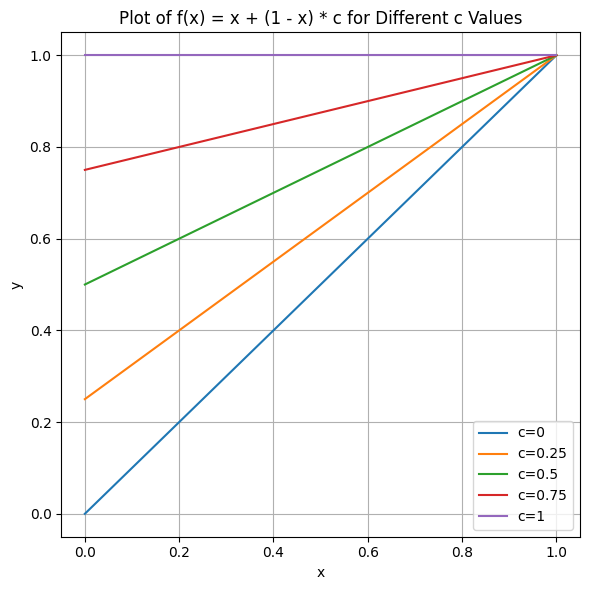

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Define x range and c values
x = np.linspace(0, 1, 1000)
cs = [0, 0.25, 0.5, 0.75, 1]

# Create plot
plt.figure(figsize=(6, 6))
for c in cs:
    y = x + (1 - x) * c
    plt.plot(x, y, label=f"c={c}")

# Set ticks on both axes
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(ticks)
plt.yticks(ticks)

# Labeling and aesthetics
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot of f(x) = x + (1 - x) * c for Different c Values")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
# plt.show()